In [1]:
import numpy as np
from lib import Experiments

In [2]:
def sample_batch(n):
    c = np.random.uniform(0, 10, size=[n, n])
    p = np.random.dirichlet(np.ones(n), size=1).ravel()
    q = np.random.dirichlet(np.ones(n), size=1).ravel()
    return c, p, q

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def load_image(filename, basewidth):
        img = Image.open(filename)
        wpercent = (basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize((basewidth, hsize), Image.ANTIALIAS)
        return np.asarray(img, dtype="int32")

def load_data(img1_path='1.png', img2_path='2.png', show=False, size=10):
        img1 = Experiments.load_image(img1_path, size)[:, :, 1]
        img2 = Experiments.load_image(img2_path, size)[:, :, 1]

        C = np.zeros((img1.shape[0] * img1.shape[1], img1.shape[0] * img1.shape[1]))

        for i in range(img1.shape[0] * img1.shape[1]):
            for j in range(img1.shape[0] * img1.shape[1]):
                C[i, j] = np.linalg.norm(np.array([i // img1.shape[0], i % img1.shape[1]]) - np.array([j // img1.shape[0], j % img1.shape[1]]), 2)

        img1 += 1
        img2 += 1
        p = img1.reshape((img1.shape[0] * img1.shape[1], )) / np.sum(img1)
        q = img2.reshape((img2.shape[0] * img2.shape[1], )) / np.sum(img2)

        if show:
            plt.figure()
            plt.subplot(121)
            plt.imshow(img1, cmap='gray')
            plt.subplot(122)
            plt.imshow(img2, cmap='gray')
            plt.show()
        return C, p, q

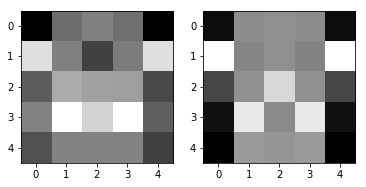

In [4]:
n = 5
c, p, q = load_data('experiments/test_data/3.png', 'experiments/test_data/4.png', show=True, size=n)
n *= n

In [5]:
import numpy as np

min_iter = 30
history = []
diff = []

class SinkhornMethod:
    def __init__(self, gamma, n=5, epsilon=0.001, epsilon_prox=0.001, log=False, prox=True):
        """
        Sinkhorn Method for Transport Problem
        :param gamma: regularizer multiplier
        :param dim: transport vector dimension
        :param epsilon: desired accuracy
        """
        # dual func variables for indicator functions
        # self.lambda_ = np.zeros(n)
        self.lambda_ = np.zeros(n)
        self.my = np.zeros(n)
        
        # constants
        self.gamma = gamma
        self.n = n
        self.epsilon = epsilon
        self.epsilon_prox = epsilon_prox
        
        self.prox = prox
        self.log = log
        if self.log:
            print("–––––––––––––––––––––––––––––")
            print("Algorithm configuration:")
            print("gamma = " + str(gamma))
            print("eps = " + str(epsilon))
            print("eps prox = " + str(self.epsilon_prox))
            print("–––––––––––––––––––––––––––––\n")
    
    def _new_dual_variables(self, C, p, q, xk):
        """
        Calculates Lagrange equation variables
        """
        self.lambda_ = self.gamma * np.log(1/p * np.sum([xk.T[j] * np.exp(-(self.gamma + C.T[j] + self.my[j])/self.gamma) for j in range(self.n)], 0))
        self.my = self.gamma * np.log(1/q * np.sum([xk[i] * np.exp(-(self.gamma + C[i] + self.lambda_[i])/self.gamma) for i in range(self.n)], 0))
       
    def _new_x(self, C, p, q, xk):
        return xk * np.exp(-(self.gamma + C + np.tile(self.lambda_, (self.n, 1)).T + np.tile(self.my, (self.n, 1)))/self.gamma)
    
    def _new_phi(self, C, p, q, xk):
        exp_ = -(C + np.tile(self.lambda_, (self.n, 1)).T + np.tile(self.my, (self.n, 1)) + self.gamma ) / self.gamma
        return - np.sum(self.lambda_ * p) - np.sum(self.my * q) - self.gamma * np.sum(xk * np.exp(exp_))
    
    def _new_f(self, C, x, xk):
        return np.sum(C * x) + self.gamma * np.sum((x + 1e-16) * np.log((x + 1e-16) / xk))
    
    def fit(self, C, p, q, with_prox=True):
        T = 0
        k = 0
        x = 1/self.n**2 * np.ones((self.n, self.n))
        while True:
            x += 1e-20
            xk = x.copy() / np.sum(x)
            
            t = 0
            while True:
                self._new_dual_variables(C, p, q, xk)
                x = self._new_x(C, p, q, xk)
                t += 1
                T += 1
                
                self.phi = self._new_phi(C, p, q, xk)
                self.f = self._new_f(C, x, xk)
                c = 1 / (2 * self.n) * (np.sum(self.my) - np.sum(self.lambda_))
                self.lambda_ += c
                self.my -= c
                
                self.epsilon_ = self.epsilon / np.sqrt(np.linalg.norm(self.lambda_, 2) ** 2 + np.linalg.norm(self.my, 2) ** 2)
                if self.log and T % 30 == 0:
                    print("Inner iteration " + str(t) + ":", "metric (one) = " + str(round((((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2), 6)), "> " + str(self.epsilon_), "or metric (two) = " + str(round(self.f - self.phi, 6)), "> " + str(self.epsilon))
                    
                if (((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2) < self.epsilon_ and self.f - self.phi < self.epsilon:
                    if self.log:
                        print("Inner iteration " + str(t) + ":", "metric (one) = " + str(round((((p - x.sum(1))**2).sum() + ((q - x.sum(0))**2).sum())**(1/2), 6)), "< " + str(self.epsilon_), "and metric (two) = " + str(round(self.f - self.phi, 6)), "< " + str(self.epsilon))
                    break
                
            if not with_prox:
                return x, T, k
            
            if self.log:
                print("– Outer iteration " + str(k) + ":", "metric = " + str(round(np.linalg.norm(x - xk, 2), 4)), "> " + str(self.epsilon_prox))
                print("- f(x) = " + str(np.sum(C * x)))
                history.append(np.sum(C * x))
                diff.append(np.linalg.norm(x - xk, 2))
            
            k += 1
            if (np.linalg.norm(x - xk, 2) < self.epsilon_prox or not self.prox) and (k >= min_iter):
                if self.log:
                    print("– Outer iteration " + str(k) + ":", "metric = " + str(round(np.linalg.norm(x - xk, 2), 7)), "< " + str(self.epsilon_prox))
                    print("- f(x) = " + str(np.sum(C * x)))
                    history.append(np.sum(C * x))
                    diff.append(np.linalg.norm(x - xk, 2))
                return x, T, k

In [6]:
# x, k, t = SinkhornMethod(gamma=1, epsilon=1e-2, epsilon_prox=1e-3, log=True, n=n).fit(c, p, q)
x, k, t = SinkhornMethod(gamma=1, epsilon=1e-2, epsilon_prox=1e-3, log=False, n=n).fit(c, p, q)
k

132

In [7]:
np.save("x", x)

In [8]:
np.log(diff)

array([], dtype=float64)

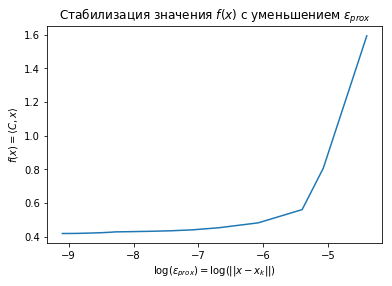

In [8]:
plt.title("Стабилизация значения $f(x)$ с уменьшением $\\varepsilon_{prox}$")
plt.xlabel("$\log(\\varepsilon_{prox}) = \log(||x - x_k||)$")
plt.ylabel("$f(x) = \langle C, x \\rangle$")
plt.plot(np.log(diff), history)
plt.savefig("fig.png", dpi=800)
plt.show()

In [3]:
# n = 40
# c, p, q = sample_batch(n)
# x, k, t = SinkhornMethod(gamma=1, epsilon=1e-2, log=True, n=n).fit(c, p, q)
# k

–––––––––––––––––––––––––––––
Algorithm configuration:
gamma = 1
eps = 0.01
eps prox = 0.001
–––––––––––––––––––––––––––––

Inner iteration 6: metric (one) = 0.000609 < 0.0006580183112924651 and metric (two) = -0.000186 < 0.01
– Outer iteration 0: metric = 0.0603 > 0.001
Inner iteration 9: metric (one) = 0.001015 < 0.0011053183438069054 and metric (two) = 0.000965 < 0.01
– Outer iteration 1: metric = 0.0165 > 0.001
Inner iteration 4: metric (one) = 0.001082 < 0.0012475644235187074 and metric (two) = 0.000371 < 0.01
– Outer iteration 2: metric = 0.0083 > 0.001
Inner iteration 5: metric (one) = 0.001197 < 0.0013047501739903663 and metric (two) = 0.000101 < 0.01
– Outer iteration 3: metric = 0.0042 > 0.001
Inner iteration 5: metric (one) = 0.001185 < 0.0013321803659573207 and metric (two) = -4.7e-05 < 0.01
– Outer iteration 4: metric = 0.0031 > 0.001
Inner iteration 3: metric (one) = 0.001151 < 0.0013466533516017217 and metric (two) = -0.000132 < 0.01
– Outer iteration 5: metric = 0.0024 

39

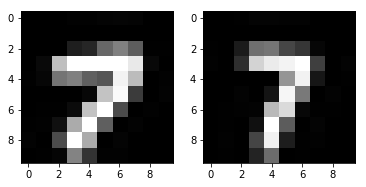

In [4]:
c_, p_, q_ = Experiments.load_data('experiments/test_data/1.png', 'experiments/test_data/2.png', show=True, size=10)
n = p_.shape[0]

In [5]:
x, k, t = SinkhornMethod(gamma=0.005, epsilon=1e-2, n=n, log=True).fit(c_, p_, q_)
k

–––––––––––––––––––––––––––––
Algorithm configuration:
gamma = 0.005
eps = 0.01
eps prox = 0.001
–––––––––––––––––––––––––––––

Inner iteration 1000: metric (one) = 0.006402 > 0.0006900847284902056 or metric (two) = -0.008605 > 0.01
Inner iteration 2000: metric (one) = 0.003344 > 0.0006288413088329059 or metric (two) = -0.004895 > 0.01
Inner iteration 3000: metric (one) = 0.002693 > 0.0006165593188641373 or metric (two) = -0.004276 > 0.01
Inner iteration 4000: metric (one) = 0.00175 > 0.0006142329136206475 or metric (two) = -0.002089 > 0.01
Inner iteration 5000: metric (one) = 0.001271 > 0.0006145334424200542 or metric (two) = -0.001361 > 0.01
Inner iteration 6000: metric (one) = 0.001267 > 0.0006133991870855702 or metric (two) = -0.001554 > 0.01
Inner iteration 7000: metric (one) = 0.001264 > 0.0006117675219676942 or metric (two) = -0.001754 > 0.01
Inner iteration 7993: metric (one) = 0.00061 < 0.000610060760456269 and metric (two) = -0.000912 < 0.01
– Outer iteration 0: metric = 0.05

8438